# Q-Learning in Reinforcement Learning

Source: [Reinforcement Learning Algorithms Tutorial (Python) from scratch](https://github.com/tsmatz/reinforcement-learning-tutorials/tree/master)

 

In reinforcement learning, the goal is to learn an optimal action–value function $ Q(s,a) $ that estimates the expected cumulative reward when taking action $ a $ in state $ s $ and then following an optimal policy. This cumulative reward is defined as
$
R = \sum_{t=0}^{\infty} \gamma^t r_t,
$

where $ r_t $ is the reward at time $ t $ and $ \gamma \in [0,1) $ is the discount factor.

### The Bellman Equation and Bellman Error

The optimal action–value function \( Q^*(s,a) \) satisfies the Bellman equation:
$
Q^*(s,a) = \mathbb{E}\Bigl[ r + \gamma \max_{a'} Q^*(s',a') \,\Big|\, s,a \Bigr],
$
where $ s' $ is the state reached from $ s $ after taking action $ a $, and $ a'$ ranges over all possible actions in the next state. The difference between the two sides of this equation is known as the **Bellman error**.

### Q-Learning Update Rule

Q-learning uses online optimization to minimize the Bellman error. In practice, when an agent takes an action $ a_t $ in state $ s_t $ and receives reward $r_t $ and the next state $ s_{t+1} $, it updates the Q-value for that state–action pair as follows:

$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \Bigl( r_t + \gamma \max_{a'} Q(s_{t+1},a') - Q(s_t,a_t) \Bigr),
$$

where:
- $ \alpha $ is the learning rate,
- $ r_t + \gamma \max_{a'} Q(s_{t+1},a') $ is the target value computed from the observed reward and the best Q-value at the next state.

This update replaces the current Q-value with a value that is closer to the target. In doing so, Q-learning iteratively minimizes the Bellman error until the Q-values converge to the optimal action–value function \( Q^*(s,a) \).
 

First, please install the required packages and import these modules.

In [ ]:
!pip install numpy gymnasium matplotlib

In [2]:
import gymnasium as gym
import numpy as np

## Discretize Cartpole States to Create an MDP with a Finite State Space

The CartPole environment provides a continuous 4-dimensional observation (each element is a float). Since primitive Q-learning requires a discrete state space, we **discretize** each continuous dimension into a fixed number of bins. In this example, we split each dimension into 20 bins. This means that a continuous state like
$$
(s_0, s_1, s_2, s_3)
$$
is converted into a tuple of four discrete indices. The conversion is done as follows:

1. **Determine the Range for Each Dimension:**  
   For dimensions 0 and 2, we use the environment’s lower and upper bounds (i.e. `env.observation_space.low[i]` and `env.observation_space.high[i]`). For dimensions 1 and 3, we fix the range as $[-4, 4]$.

2. **Compute Equally-Spaced Bin Boundaries:**  
   Using `np.linspace`, we generate 20 equally spaced points over the chosen range. With the parameter `endpoint=False`, the upper bound is not included so that we get the left edge of each bin. Then we remove the first bin edge (using `np.delete`) to slightly shift the bin boundaries.  
   The result is that each bin represents a segment of the continuous range.

3. **Map a Continuous Value to a Discrete Bin:**  
   For each dimension of a continuous state, we use `np.digitize` along with the precomputed bin boundaries to find out into which bin the value falls. The output is a discrete index (for example, 0 to 19) that represents the bin.



Creating bins for each dimension:

Dimension 0:
  Range: [-4.80, 4.80]
  Number of bins: 20
  Bin boundaries:
[ -4.32  -3.84  -3.36  -2.88  -2.40  -1.92  -1.44  -0.96  -0.48   0.00
   0.48   0.96   1.44   1.92   2.40   2.88   3.36   3.84   4.32]

Dimension 1:
  Range: [-4.00, 4.00]
  Number of bins: 20
  Bin boundaries:
[ -3.60  -3.20  -2.80  -2.40  -2.00  -1.60  -1.20  -0.80  -0.40   0.00
   0.40   0.80   1.20   1.60   2.00   2.40   2.80   3.20   3.60]

Dimension 2:
  Range: [-0.42, 0.42]
  Number of bins: 20
  Bin boundaries:
[ -0.38  -0.34  -0.29  -0.25  -0.21  -0.17  -0.13  -0.08  -0.04   0.00
   0.04   0.08   0.13   0.17   0.21   0.25   0.29   0.34   0.38]

Dimension 3:
  Range: [-4.00, 4.00]
  Number of bins: 20
  Bin boundaries:
[ -3.60  -3.20  -2.80  -2.40  -2.00  -1.60  -1.20  -0.80  -0.40   0.00
   0.40   0.80   1.20   1.60   2.00   2.40   2.80   3.20   3.60]


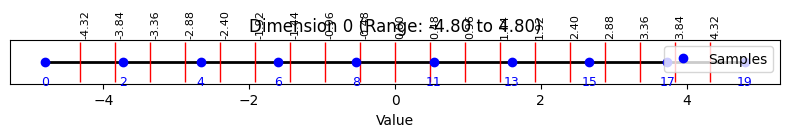

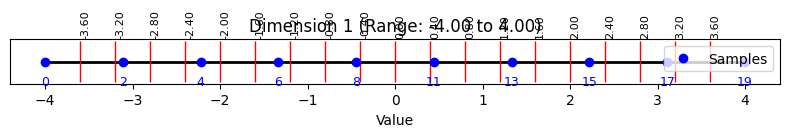

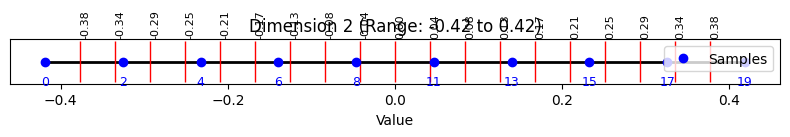

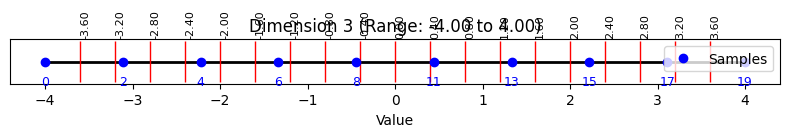

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")

# Number of bins for each of the 4 dimensions.
new_observation_shape = (20, 20, 20, 20)

bins = []
print("Creating bins for each dimension:")
for i in range(4):
    # For dimensions 0 and 2, use environment's actual bounds.
    # For dimensions 1 and 3, use fixed bounds of -4 to 4.
    low_bound = env.observation_space.low[i] if i in [0, 2] else -4
    high_bound = env.observation_space.high[i] if i in [0, 2] else 4

    # Generate equally spaced bin boundaries.
    item = np.linspace(low_bound, high_bound, num=new_observation_shape[i], endpoint=False)
    # Remove the first element to shift boundaries (optional tweak).
    item = np.delete(item, 0)
    bins.append(item)
    
    # Print informative information.
    print(f"\nDimension {i}:")
    print(f"  Range: [{low_bound:.2f}, {high_bound:.2f}]")
    print(f"  Number of bins: {new_observation_shape[i]}")
    print("  Bin boundaries:")
    print(np.array2string(item, formatter={'float_kind': lambda x: f"{x:6.2f}"}))

# Function to convert a continuous state to a discrete state.
def get_discrete_state(s):
    new_s = []
    for i in range(4):
        # np.digitize returns the index of the bin into which the value falls.
        new_s.append(np.digitize(s[i], bins[i]))
    return new_s

# Visualize the bins and sample discretization for each dimension.
for i in range(4):
    fig, ax = plt.subplots(figsize=(8, 1.5))
    # Determine bounds for plotting.
    low_bound = env.observation_space.low[i] if i in [0, 2] else -4
    high_bound = env.observation_space.high[i] if i in [0, 2] else 4
    
    # Plot a horizontal line representing the continuous range.
    ax.hlines(0, low_bound, high_bound, color='black', lw=2)
    
    # Plot vertical lines at each bin boundary.
    for b in bins[i]:
        ax.vlines(b, -0.3, 0.3, color='red', lw=1)
        ax.text(b, 0.35, f"{b:.2f}", rotation=90, verticalalignment='bottom', fontsize=8)
    
    # Plot some sample values along the range.
    sample_vals = np.linspace(low_bound, high_bound, 10)
    discrete_vals = [np.digitize(val, bins[i]) for val in sample_vals]
    ax.plot(sample_vals, np.zeros_like(sample_vals), 'bo', label="Samples")
    for val, d in zip(sample_vals, discrete_vals):
        ax.text(val, -0.35, f"{d}", ha='center', fontsize=9, color='blue')
    
    ax.set_title(f"Dimension {i} (Range: {low_bound:.2f} to {high_bound:.2f})")
    ax.set_xlabel("Value")
    ax.set_yticks([])
    ax.legend()
    plt.tight_layout()
    plt.show()

Now we generate Q-Table $Q(s,a)$ and initialize all values by 0. (Here it's 5 dimensional table.)

In [5]:
q_table = np.zeros(new_observation_shape + (env.action_space.n,))
q_table.shape

(20, 20, 20, 20, 2)

## Update Q-Table with Q-Learning algorithm.

 

### Key Points

- **Epsilon-Greedy Sampling:**  
  The function `epsilon_greedy_sampling(s, epsilon)` selects the best action (with maximum Q-value) for state `s` with probability $1-\epsilon$ and chooses a random action with probability $\epsilon$. This is a common strategy to balance exploration and exploitation.

  We first set $\epsilon = 1$, i.e., randomly sample actions and then gradually decrease the value of $\epsilon$.

- **Q-Table Update (Key Code):**  
  In the inner loop of each episode, the Q-table is updated using the rule:
  ```python
  q_table[tuple(s_dis)][a] += alpha * (r + gamma * np.max(q_table[tuple(s_dis_next)]) - q_table[tuple(s_dis)][a])
  ```
  Here:
  - `r` is the immediate reward.
  - `gamma * np.max(q_table[tuple(s_dis_next)])` represents the estimated maximum future reward.
  - The difference is the **Bellman error**, which is scaled by the learning rate `alpha` and used to update the current Q-value.



In [10]:
# Hyperparameters
gamma = 0.99          # Discount factor
alpha = 0.1           # Learning rate
epsilon = 1.0         # Initial exploration rate
n_episodes = 6000
epsilon_decay = 1.5 * epsilon / n_episodes  # Decay per episode

# Epsilon-greedy sampling function
def epsilon_greedy_sampling(s, epsilon):
    """
    Select an action using an epsilon-greedy strategy.
    With probability 1-epsilon, choose the best action from the Q-table for state s.
    Otherwise, choose a random action.
    """
    if np.random.random() > epsilon:
        return np.argmax(q_table[tuple(s)])
    else:
        return np.random.randint(0, env.action_space.n)

# Q-learning loop
reward_records = []


for i in range(n_episodes):
    done = False
    total_reward = 0
    # Reset the environment and get the initial continuous state.
    s, _ = env.reset()
    s_dis = get_discrete_state(s)

    while not done:
        # Select action using epsilon-greedy sampling
        a = epsilon_greedy_sampling(s_dis, epsilon)
        
        # Take the action and receive the next state and reward.
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        s_dis_next = get_discrete_state(s)

        # --- Key Q-table update code ---
        # Update the Q-table using the Bellman update rule.
        maxQ_next = np.max(q_table[tuple(s_dis_next)])
        q_table[tuple(s_dis)][a] += alpha * (r + gamma * maxQ_next - q_table[tuple(s_dis)][a])
        # ----------------------------------

        s_dis = s_dis_next
        total_reward += r

    # Decay epsilon after each episode
    epsilon = max(epsilon - epsilon_decay, 0)

    reward_records.append(total_reward)
    if i % 500 == 0:
        print(f"Episode {i:4d}: Total Reward = {total_reward:3f}, Epsilon = {epsilon:.3f}")

print("\nTraining completed!")
env.close()



Episode    0: Total Reward = 18.000000, Epsilon = 1.000
Episode  500: Total Reward = 9.000000, Epsilon = 0.875
Episode 1000: Total Reward = 12.000000, Epsilon = 0.750
Episode 1500: Total Reward = 24.000000, Epsilon = 0.625
Episode 2000: Total Reward = 15.000000, Epsilon = 0.500
Episode 2500: Total Reward = 152.000000, Epsilon = 0.375
Episode 3000: Total Reward = 171.000000, Epsilon = 0.250
Episode 3500: Total Reward = 236.000000, Epsilon = 0.125
Episode 4000: Total Reward = 500.000000, Epsilon = 0.000
Episode 4500: Total Reward = 500.000000, Epsilon = 0.000
Episode 5000: Total Reward = 500.000000, Epsilon = 0.000
Episode 5500: Total Reward = 500.000000, Epsilon = 0.000

Training completed!


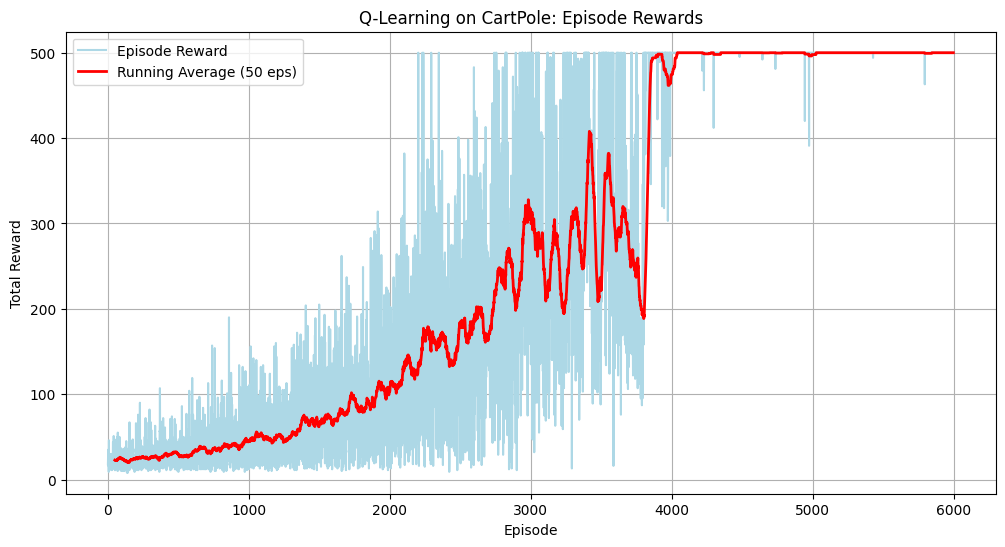

In [11]:
# Visualization: Plot raw rewards and a 50-episode running average
window_size = 50
running_avg = np.convolve(reward_records, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(12, 6))
plt.plot(reward_records, color='lightblue', label='Episode Reward')
plt.plot(range(window_size-1, n_episodes), running_avg, color='red', linewidth=2, label='Running Average (50 eps)')
plt.title("Q-Learning on CartPole: Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

As you can see above, this method won't work in large continuous and stochastic spaces (e.g, continuos action space), since this method will need so many discrete mesh for solving problems.<br>
